In [73]:
import redis
import json
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
import contractions
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
r = redis.Redis(host='redis-12442.c90.us-east-1-3.ec2.cloud.redislabs.com',port=12442,password='RHFgwK2pQ2ibFUqw8zrQBHRzK29lQtDw')
keys=r.keys('*') #getting the keys of each convesation
print(len(keys))

71


In [62]:
trackerdata=[]
for i in keys: 
    temp=r[i]
    temp = temp.decode("utf-8")
    trackerdata.append(json.loads(temp)) #each conversation is saved with its events as a list and trackername
conversations=[]
for i in trackerdata:
    conversations.append(i["events"]) #extracting only the events list of each conversation
intents=set()
intentdictnew=dict()
for conv in conversations:
    for i in conv:
        if i['event']=="user":
            if i['parse_data']['intent']['name'] not in intents:
                intents.add(i['parse_data']['intent']['name'])
                intentdictnew[i['parse_data']['intent']['name']]={i["text"]}
            else:
                intentdictnew[i['parse_data']['intent']['name']].add(i["text"])
for k,v in intentdictnew.items():
    print(k,":",v)


price_details : {'price details', 'price detaosl', 'price detaisl', '/price_details'}
get_item_prices : {'/get_item_prices', 'item ifno'}
get_specific_price : {'cost of particular item', '/get_specific_price', 'particular item particular location'}
item_details : {'100185305', '105', '100150000', '1000350001', '100035001', '607'}
location_details : {'loc is 607', 'location 607', 'location 105', 'loc 607', 'price details for location 607'}
get_item_all_locs : {'UPC in RMS', '/get_item_all_locs', 'cost of all items in particular location'}
greet : {"how's the weather", "how's the weather like", 'hey', 'what is atmosphere', 'sup', 'Oracle', 'atmosphere', 'hi'}
user_query : {'/item_details', 'item info]', 'item info'}
location_info : {'location 246001', '100035001', '100150000'}
hello : {'/hello'}
nlu_fallback : {'prime minister of india', 'what is climatic change', 'who is vendor', 'UPC in retail', 'president of india', 'rasa', 'list IT companies chennai', 'what is the wetaher like', '/ac

DESCRIPTIVE ANALYSIS OF UNRECOGNISED USER INPUTS

In [118]:
print(intentdictnew["nlu_fallback"])
print(intentdictnew["others"])
newinputs=intentdictnew["nlu_fallback"] | intentdictnew["others"]
print(newinputs)

{'prime minister of india', 'what is climatic change', 'who is vendor', 'UPC in retail', 'president of india', 'rasa', 'list IT companies chennai', 'what is the wetaher like', '/action_get_item_prices', 'what is UPC', '100035001', 'UPC', 'what is the weather condition in trichy', '607', 'loc is 607', '100150000', 'what is RASA', 'prime minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'cheif minister of tamilnadu'}
{'what is the weather', 'hwta is UPC', 'what is python', '/others', 'who is the cheif minister of tamilnadu', 'what is the weather in trichy', 'what is the weather like', 'what is the weather in chennai', 'what is RMS'}
{'UPC', 'what is the weather condition in trichy', 'prime minister of india', 'what is climatic change', 'what is the weather', 'what is python', '607', 'what is the weather in trichy', 'who is vendor', 'UPC in retail', 'president of india', 'rasa', 'list IT companies chennai', 'what is the wetaher like', '/action_get_item_prices', 'loc is 60

PREPROCESSING THE DATA

In [119]:
#removing button inputs
newinputs2=set()
for i in newinputs:
    if i[0]!='/':
        newinputs2.add(i.lower())
newinputs2=list(newinputs2)
print(newinputs2)

['prime minister of india', 'what is climatic change', 'what is python', 'what is the weather in trichy', 'who is vendor', 'list it companies chennai', 'president of india', 'rasa', 'what is rasa', 'what is the wetaher like', 'what is rms', '100035001', 'what is upc', 'who is the cheif minister of tamilnadu', 'what is the weather like', 'what is the weather in chennai', 'what is the weather condition in trichy', 'what is the weather', '607', 'upc', 'upc in retail', 'loc is 607', '100150000', 'hwta is upc', 'prime minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'cheif minister of tamilnadu']


In [66]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [67]:
def cleaning_contractions(text):
    text=text.split()
    corrected=[]
    for word in text:
        corrected.append(contractions.fix(word))
    return " ".join(corrected)

In [70]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    return re.sub(re.compile("["+punctuations_list+"‼️’]")," ",text)

In [74]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
def cleaning_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\metul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
def correct_word_spelling(sentence):
    words=sentence.split()
    words2=[]
    for word in words:
        word = Word(word)
        words2.append(word.correct())
    return(" ".join(words2))

In [120]:
#performing all data cleaning operations
cleanedinputs=[]
wordmap=dict()
for i in newinputs2:
    temp=cleaning_numbers(i)
    temp=cleaning_contractions(temp)
    #temp=correct_word_spelling(temp)
    temp=cleaning_punctuations(temp)
    temp=cleaning_stopwords(temp)
    if temp!="":
        cleanedinputs.append(temp)
        keys=set(wordmap.keys())
        for j in temp.split():
            if j not in keys:
                wordmap[j]=[i]
            else:
                wordmap[j].append(i) #mapping the maps their sentences


In [121]:
#print(wordmap)
for k,v in wordmap.items():
    print(k,": ",v)

prime :  ['prime minister of india', 'prime minister of tamilnadu']
minister :  ['prime minister of india', 'who is the cheif minister of tamilnadu', 'prime minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'cheif minister of tamilnadu']
india :  ['prime minister of india', 'president of india']
climatic :  ['what is climatic change']
change :  ['what is climatic change']
python :  ['what is python']
weather :  ['what is the weather in trichy', 'what is the weather like', 'what is the weather in chennai', 'what is the weather condition in trichy', 'what is the weather']
trichy :  ['what is the weather in trichy', 'what is the weather condition in trichy']
vendor :  ['who is vendor']
list :  ['list it companies chennai']
companies :  ['list it companies chennai']
chennai :  ['list it companies chennai', 'what is the weather in chennai']
president :  ['president of india']
rasa :  ['rasa', 'what is rasa']
wetaher :  ['what is the wetaher like']
like :  ['what is the weta

In [132]:
words=[]
for i in cleanedinputs:
    words.extend(i.split())
#print(words)
wordcount=Counter(words) #counting occurance of each word
print(wordcount)

Counter({'minister': 5, 'weather': 5, 'upc': 4, 'tamilnadu': 4, 'prime': 2, 'india': 2, 'trichy': 2, 'chennai': 2, 'rasa': 2, 'like': 2, 'cheif': 2, 'climatic': 1, 'change': 1, 'python': 1, 'vendor': 1, 'list': 1, 'companies': 1, 'president': 1, 'wetaher': 1, 'rms': 1, 'condition': 1, 'retail': 1, 'loc': 1, 'hwta': 1, 'cheoif': 1})


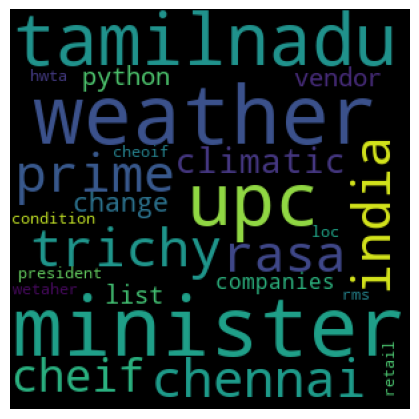

In [131]:
comment_words = " ".join(words)+ " "
#print(comment_words)
wordcloud = WordCloud(width = 300, height = 300,background_color ='black',min_font_size = 10).generate(comment_words)
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
